# Deep learning : Petals to the metal

Buchin Nathan 18092,
Zhao Yiming 195187

The objective of this kaggle challenge is to create a model that will be able to detect to which flower specie corresponds a given image. To do so, we trained a Convolutionnal Neural Network then explored the power of transfer learning.

In [1]:
import math, re, os
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

D0521 20:07:24.962491001      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0521 20:07:24.962528205      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0521 20:07:24.962532173      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0521 20:07:24.962534919      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0521 20:07:24.962537399      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0521 20:07:24.962540344      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0521 20:07:24.962543316      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0521 20:07:24.

## Settings for using TPU

In [2]:
# tpu strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


### Kaggle images folder path

In [3]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'
#In our case, we are only using a part of all the available images, we are only dealing with the 512x512 format

print(GCS_DS_PATH)

/kaggle/input/tpu-getting-started


get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tpu-getting-started


# Taking all the files for our 512x512 image path


In [4]:
# Since we said earlier that we are only focusing on the 512x512 format, we define this format size
IMAGE_SIZE = [512, 512]

AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

## All the possible flower species of our classification problem
In this challenge, there 104 types of flowers

In [5]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

print(len(CLASSES))

104


In [6]:
# **these functions were picked from a kaggle notebook and they will handle the preprocessing of our original images**

# here the purpose of the function is to perform standardization, we want to be able to evaluate each images on the same basis : floats in the range [0,1] 
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

# this function interprets the label to make our model understand what's the label of given image of the trainning dataset
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

# this function is quite similiar to the previous one, but adapted to deal with unlabeled images
def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

Data augmentation is quite similar to feature engeneering in machine learning in the way that it helps to make the most of the data.
But it's also a way to avoid overfitting, we don't want for example a model that will only be able to recognize a species by it's orientation. So creating new images with other orientation can be usefull to our model to learn to match a species pattern not beeing to much influenced by the object orientation or image brightness. The classical techniques used are flipping the image and playing with it's saturation. 

In [7]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat(10)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # get next batch while training 
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE) 
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


# Creating our datasets

In [8]:
# Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
# it represent the amount of images given at the same time to the model, a high value will help to reduce computation time but it may underperform
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


# Creating a CNN 

In the beginning, we only submitted a baseline model containning only our model built with 4 convolution layers.\
We had a 30% score and optimizing at this point was not the first thing to do but rather use transfer learning. Transfer learning will allow us to recycle some old model with it's pretrained weights and the approach here is to attach a 'head' to this model to make it converge to our flowers species.

Our initial thoughs were that using only the pretrained model may not lead to decent accuracy, maybe the images of our dataset are not that similar to the ones that trained Xception. But of course, Xception as a base of the cnn will be a pretty strong base. 

So at this point, we are just using here the Xception knowledge and make it act as a classifier. All we want to do is some fine-tuning, we don't want to modify the tansfered model, that's why we kept the trainable property at false for each models tried.


The model kept here is Xception since it provided a decent accuracy increase. 
Using the pretrained Xception model, we obtained 66% and then went to 
70% when we added Batch normalization and dropout, the purpose of these two things is to avoid having some weights becoming too important and too specific to a pattern.

But then we tried to add a better head to Xception :
<li>we used GlobalAveragePooling2D that will help the model to perform better by making a downsample on the inputs, by reducing the dimensions while preserving important features. That way, the model is focused on a more relevant input. <li>we used dense layers to create a deeper model and so to help him to detect more complex patterns. 
    
And this strategy got us 10% accuracy increase.


In [16]:

with strategy.scope():
#     pretrained_model = tf.keras.applications.resnet50.ResNet50(
#         weights='imagenet',
#         include_top=False ,
#         input_shape=[*IMAGE_SIZE, 3]
        
#     )
#     pretrained_model = tf.keras.applications.VGG16(
#         weights='imagenet',
#         include_top=False ,
#         input_shape=[*IMAGE_SIZE, 3]
#     )




    pretrained_model = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
        
    )
    # we don't want to allow our pre-trained model to adapt it's weights
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential([
        pretrained_model,
        
        
        #FIRST APPROACH : make our own pattern recognition using convolution
#         # First Convolutional Block : the input of our network is constraint to have the image dimension (512 by 512 rgb pixels )
#         tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',input_shape= [*IMAGE_SIZE, 3]),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.MaxPool2D(),

#         # Second Convolutional Block
#         tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
#         tf.keras.layers.Dropout(0.25),
#         tf.keras.layers.MaxPool2D(),

#         # Third Convolutional Block
#         tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.MaxPool2D(),

#         # Third Convolutional Block
#         tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
#         tf.keras.layers.Dropout(0.25),
#         tf.keras.layers.MaxPool2D(),
        
        # LAST APPROACH
        # downsampling operation to reduce spatial dimensions while preserving important features.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.1),

        
        # Classifier Head
        tf.keras.layers.Flatten(),
        # for the output, since we are in a multi class, we need as many units as there are classes
        tf.keras.layers.Dense(units=len(CLASSES), activation="softmax"),


    ])

In [17]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 16, 16, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                      

An epoch represents a complete pass through the entire training dataset. During an epoch, the model is trained on each training sample in the dataset, and the weights are updated based on the calculated gradients. The number of epochs is a hyperparameter that determines how many times the model will iterate over the entire training dataset. \
In each epoch, the model gradually adjusts its weights to minimize the loss function and improve its ability to make accurate predictions. By training over multiple epochs, the model can refine its parameters and capture complex patterns in the data. Here since the dataset size is relatively big an computing time is also quite long, we kept our epoch value to 20. Going lower than 10 wasn't allowing our model to make a good learning,but we havn't experience going higher then 20.

In [18]:
# 20 iterations trough all learning data
EPOCHS = 20
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)

Epoch 1/20


2023-05-21 20:51:28.774422: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-21 20:51:28.999499: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - ETA: 0s - loss: 3.1786 - sparse_categorical_accuracy: 0.2755

2023-05-21 20:52:21.664921: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-21 20:52:21.865848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - 78s 574ms/step - loss: 3.1786 - sparse_categorical_accuracy: 0.2755 - val_loss: 2.1606 - val_sparse_categorical_accuracy: 0.4550
Epoch 2/20
99/99 [==============================] - 42s 430ms/step - loss: 2.0695 - sparse_categorical_accuracy: 0.4676 - val_loss: 1.6497 - val_sparse_categorical_accuracy: 0.5663
Epoch 3/20
99/99 [==============================] - 43s 434ms/step - loss: 1.5880 - sparse_categorical_accuracy: 0.5779 - val_loss: 1.3324 - val_sparse_categorical_accuracy: 0.6509
Epoch 4/20
99/99 [==============================] - 44s 443ms/step - loss: 1.3996 - sparse_categorical_accuracy: 0.6199 - val_loss: 1.2398 - val_sparse_categorical_accuracy: 0.6740
Epoch 5/20
99/99 [==============================] - 45s 457ms/step - loss: 1.2289 - sparse_categorical_accuracy: 0.6651 - val_loss: 1.0977 - val_sparse_categorical_accuracy: 0.7069
Epoch 6/20
99/99 [==============================] - 44s 443ms/step - loss: 1.0770 - sparse_categorical_acc

Learning process to find the optimal parameters that gets the best accuracy. The iterative training process continues until a stopping criterion is met, in our case it's the maximum number of epochs. 

# Plotting model loss and accuracy 

The relevant information retreived from these plots are the gap we can have between our trainning and validation. With our baseline model, the gap was important. 

Integrating the Xception pretrained model immediatly performed better and showed less overfitting.

To deal with this gap problem, we started adding dropouts and batch normalization to avoid some neuron's to become too specific in the pattern matching.





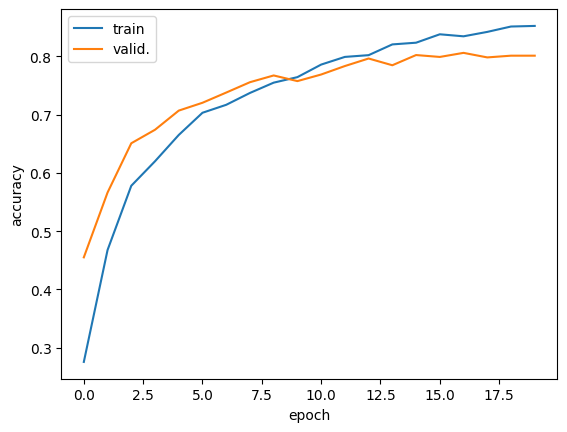

In [19]:
plt.plot(history.history['sparse_categorical_accuracy'], 
         label='model accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], 
         label='model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'valid.'])
plt.show()



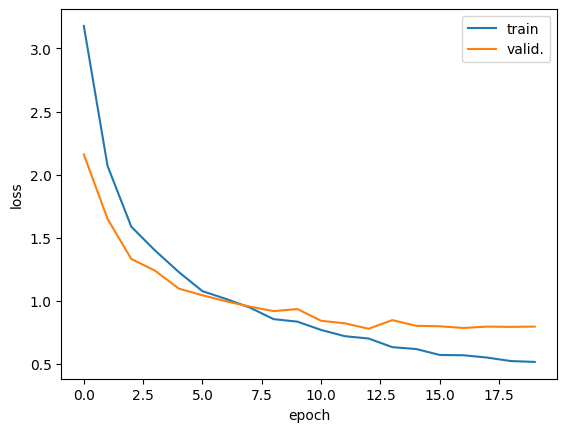

In [20]:
plt.plot(history.history['loss'], 
         label='model loss')
plt.plot(history.history['val_loss'], 
         label='model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid.'])
plt.show()

# Predictions

In [21]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...


2023-05-21 21:08:04.894467: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-21 21:08:05.059474: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


58/58 [==============================] - 46s 511ms/step
[ 13  66 103 ...  49  45  86]


# Submission

In [22]:
print('Generating submission.csv file...')

# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

Generating submission.csv file...
id,label
0b9afbdf2,13
c37a6f3e9,66
00e4f514e,103
1c4736dea,28
252d840db,67
dfc9c6a23,103
53cfc6586,46
541c4d41e,53
59d1b6146,62
